# 1. Imports

In [1]:
#!pip install tensorflow opencv-python mediapipe matplotlib

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import os

# 2. Keypoint Using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils #drawing utilities

In [3]:
#mediapipe function
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = model.process(image) #make prediction from image
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    # Doesnt return landmarks instead applies to frame
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), #colours landmark (dot)
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) # colours connections (lines)

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 


    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))


    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 

# 3. Extract Keypoints

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, left_hand, right_hand])

# 4. Setup Folders For Collection

In [7]:
# Path for exported data (numpy array)
DATA_PATH = os.path.join('Action_Dataset')

# Actions to detect
actions = np.array(['thanks'])

no_sequence = 150

# 30 frames per video
sequence_length = 30

In [8]:
for action in actions:
    for sequence in range(no_sequence): 
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Keypoint Collection

In [ ]:
cap = cv2.VideoCapture(0) # Accessing webcam
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
     
    #loop through actions
    for action in actions:
        #loop through videos
        for sequence in range(no_sequence):
            #loop through frames per video
            for frame_num in range(sequence_length):
                
                # Read feed
                ret, frame = cap.read()
            
                # Make detection
                image, results = mediapipe_detection(frame, holistic)
                #print(results)
        
                # Draw landmarks
                draw_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} video number {}'.format(action, sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} video number {}'.format(action, sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                #extract keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                                


                #to break
                if cv2.waitKey(10) & 0xFF == ord('q'): # If key = 'q' then quit
                    break
    cap.release()
    cv2.destroyAllWindows()

In [13]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
DATA_PATH = os.path.join('Action_Dataset')
actions = np.array([folder for folder in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, folder))])
print(actions)

['drink' 'eat, food' 'family' 'go' 'happy' 'help' 'hospital' 'medicine'
 'no' 'now' 'sleep' 'thankyou' 'toilet' 'where' 'yes']


In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequence):
        window = []  #video
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [13]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)


# For stratification, train_test_split needs the original integer labels, not one-hot encoded
# Let's get the original integer labels from the one-hot encoded 'y'
y_labels = np.argmax(y, axis=1)

In [14]:
# Split data into training (e.g., 80%) and temp (validation + test, e.g., 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_labels) # Added random_state for reproducibility

# For the second split, we need the integer labels corresponding to y_temp
y_temp_labels = np.argmax(y_temp, axis=1)

# Split temp into validation (e.g., 10% of original) and test (e.g., 10% of original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp_labels) # 0.5 of 0.2 is 0.1

# 7. Build and Train Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [16]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [17]:
# Add Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) # Monitor validation loss, stop after 50 epochs without improvement, restore best model weights

In [ ]:
#LSTM
model1 = Sequential()
model1.add(LSTM(128, return_sequences=False, input_shape=(30, 1662)))
model1.add(Dropout(0.5))
model1.add(BatchNormalization()) 
model1.add(Dense(64, activation='relu'))
model1.add(Dense(actions.shape[0], activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Ukasy\anaconda3\envs\MAIN\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
history1 = model1.fit(X_train, y_train, epochs=400, callbacks=[tb_callback, early_stopping], validation_data=(X_val, y_val))
model1.save('model1.h5')
model1.summary()

Epoch 1/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.0728 - loss: 2.9788 - val_accuracy: 0.2000 - val_loss: 2.6226
Epoch 2/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.2195 - loss: 2.2768 - val_accuracy: 0.3778 - val_loss: 2.2990
Epoch 3/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3370 - loss: 1.8931 - val_accuracy: 0.4044 - val_loss: 1.9451
Epoch 4/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4016 - loss: 1.6227 - val_accuracy: 0.4444 - val_loss: 1.5628
Epoch 5/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4736 - loss: 1.4302 - val_accuracy: 0.4978 - val_loss: 1.2975
Epoch 6/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5313 - loss: 1.2176 - val_accuracy: 0.5956 - val_loss: 0.9630
Epoch 7/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5466 - loss: 1.1438 - val_accuracy: 0.5956 - val_loss: 0.8758
Epoch 8/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5713 - loss: 1.0073 - val_accuracy: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       916,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,695 (10.60 MB)

 Trainable params: 926,479 (3.53 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,852,960 (7.07 MB)

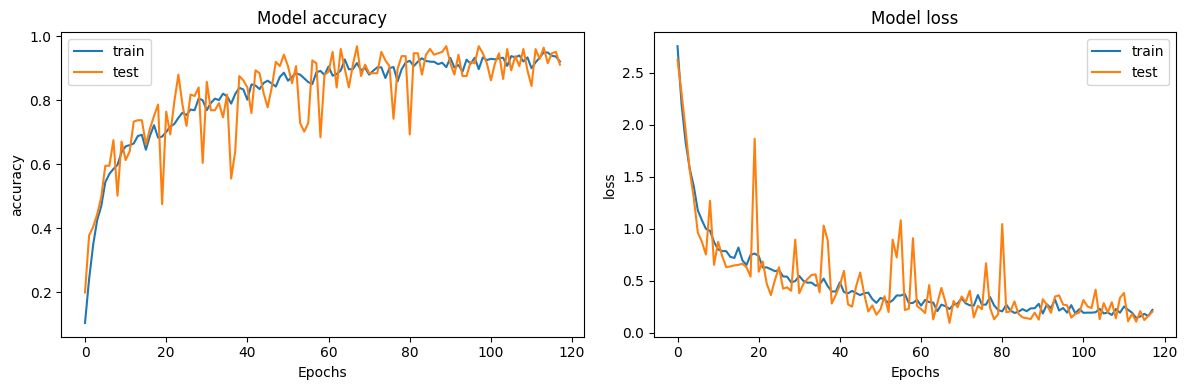

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#BiLSTM
from tensorflow.keras.layers import Bidirectional

model2 = Sequential()
model2.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(30, 1662)))
model2.add(Dropout(0.4))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(actions.shape[0], activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Ukasy\anaconda3\envs\MAIN\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:

history2 = model2.fit(X_train, y_train, epochs=400, callbacks=[tb_callback, early_stopping], validation_data=(X_val, y_val))
model2.save('model2.h5')

Epoch 1/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.0751 - loss: 2.7052 - val_accuracy: 0.1733 - val_loss: 2.4400
Epoch 2/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.1460 - loss: 2.3181 - val_accuracy: 0.2178 - val_loss: 1.9428
Epoch 3/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2178 - loss: 1.9745 - val_accuracy: 0.2044 - val_loss: 1.9874
Epoch 4/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.2751 - loss: 1.7947 - val_accuracy: 0.1911 - val_loss: 2.1934
Epoch 5/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2930 - loss: 1.7859 - val_accuracy: 0.3778 - val_loss: 1.4748
Epoch 6/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3892 - loss: 1.5262 - val_accuracy: 0.3689 - val_loss: 1.4300
Epoch 7/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4592 - loss: 1.3214 - val_accuracy: 0.3867 - val_loss: 1.4550
Epoch 8/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4775 - loss: 1.2782 - val_accuracy: 0

In [24]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │       884,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,791,727 (10.65 MB)

 Trainable params: 930,575 (3.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,861,152 (7.10 MB)

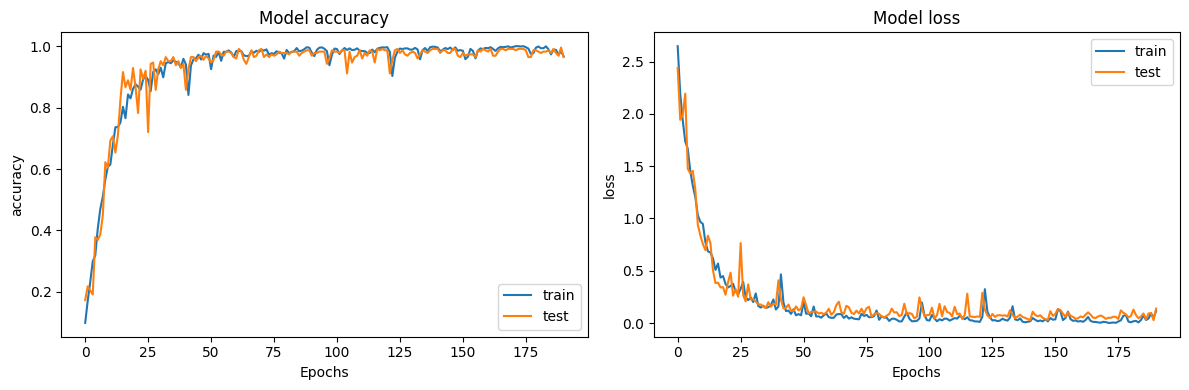

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#BiGRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, BatchNormalization

model3 = Sequential()
model3.add(Bidirectional(GRU(128, return_sequences=False), input_shape=(30, 1662)))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(actions.shape[0], activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:

history3 = model3.fit(X_train, y_train, epochs=400, callbacks=[tb_callback, early_stopping], validation_data=(X_val, y_val))
model3.save('model3.h5')
model3.summary()

Epoch 1/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.0892 - loss: 3.0460 - val_accuracy: 0.1333 - val_loss: 2.5622
Epoch 2/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.1782 - loss: 2.4007 - val_accuracy: 0.3200 - val_loss: 2.1399
Epoch 3/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2763 - loss: 2.0329 - val_accuracy: 0.3822 - val_loss: 1.8971
Epoch 4/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.3513 - loss: 1.7906 - val_accuracy: 0.4222 - val_loss: 1.6512
Epoch 5/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4388 - loss: 1.5632 - val_accuracy: 0.5422 - val_loss: 1.3802
Epoch 6/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4752 - loss: 1.3631 - val_accuracy: 0.5467 - val_loss: 1.1400
Epoch 7/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5277 - loss: 1.2525 - val_accuracy: 0.6711 - val_loss: 1.0263
Epoch 8/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5467 - loss: 1.1448 - val_accuracy: 0

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 256)            │     1,376,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,183,087 (15.96 MB)

 Trainable params: 1,394,191 (5.32 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 2,788,384 (10.64 MB)

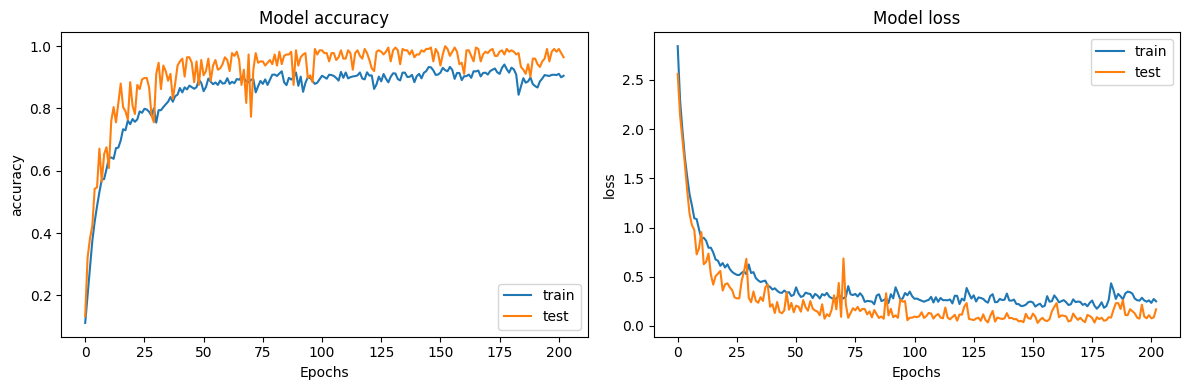

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Example for one model
test_loss1, test_acc1 = model1.evaluate(X_test, y_test)
test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
test_loss3, test_acc3 = model3.evaluate(X_test, y_test)

# Get predictions
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
preds3 = model3.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9428 - loss: 0.1523
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9839 - loss: 0.0823   
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9789 - loss: 0.0956
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [45]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_pred1 = np.argmax(preds1, axis=1)
y_pred2 = np.argmax(preds2, axis=1)
y_pred3 = np.argmax(preds3, axis=1)

# Get unique labels present in the true and predicted values for evaluation metrics
unique_labels_eval = np.unique(np.concatenate((y_true, y_pred2)))
# Filter action names to match the unique labels present in the evaluation data
eval_target_names = [actions[i] for i in unique_labels_eval]

print("LSTM Classification Report:\n", classification_report(y_true, y_pred1, labels=unique_labels_eval, target_names=eval_target_names))
print("BiLSTM Classification Report:\n", classification_report(y_true, y_pred2, labels=unique_labels_eval, target_names=eval_target_names))
print("GRU Classification Report:\n", classification_report(y_true, y_pred3, labels=unique_labels_eval, target_names=eval_target_names))

LSTM Classification Report:
               precision    recall  f1-score   support

       drink       0.88      1.00      0.94        15
   eat, food       0.93      0.87      0.90        15
      family       1.00      1.00      1.00        15
          go       1.00      0.93      0.97        15
       happy       1.00      1.00      1.00        15
        help       1.00      1.00      1.00        15
    hospital       1.00      1.00      1.00        15
    medicine       1.00      1.00      1.00        15
          no       0.91      0.67      0.77        15
         now       0.94      1.00      0.97        15
       sleep       1.00      0.93      0.97        15
    thankyou       0.94      1.00      0.97        15
      toilet       1.00      0.87      0.93        15
       where       0.94      1.00      0.97        15
         yes       0.74      0.93      0.82        15

    accuracy                           0.95       225
   macro avg       0.95      0.95      0.95       2

In [37]:
# Soft voting ensemble
ensemble_preds = (preds1 + preds2 + preds3) / 3.0
ensemble_pred_labels = np.argmax(ensemble_preds, axis=1)

# Evaluate ensemble
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

ensemble_acc = accuracy_score(y_true, ensemble_pred_labels)
print("Ensemble Accuracy:", ensemble_acc)
print("Ensemble Classification Report:\n", classification_report(y_true, ensemble_pred_labels))
print("Ensemble Confusion Matrix:\n", confusion_matrix(y_true, ensemble_pred_labels))

Ensemble Accuracy: 0.9866666666666667
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       0.94      1.00      0.97        15
           6       1.00      1.00      1.00        15
           7       1.00      0.93      0.97        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       0.94      1.00      0.97        15
          12       1.00      0.87      0.93        15
          13       0.94      1.00      0.97        15
          14       1.00      1.00      1.00        15

    accuracy                           0.99       225
   macro 

In [38]:
import numpy as np

# Get predicted probabilities
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
preds3 = model3.predict(X_test)

# Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test, axis=1)

# Get predicted class labels
y_pred1 = np.argmax(preds1, axis=1)
y_pred2 = np.argmax(preds2, axis=1)
y_pred3 = np.argmax(preds3, axis=1)

# Ensemble (soft voting)
ensemble_probs = (preds1 + preds2 + preds3) / 3.0
y_pred_ensemble = np.argmax(ensemble_probs, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


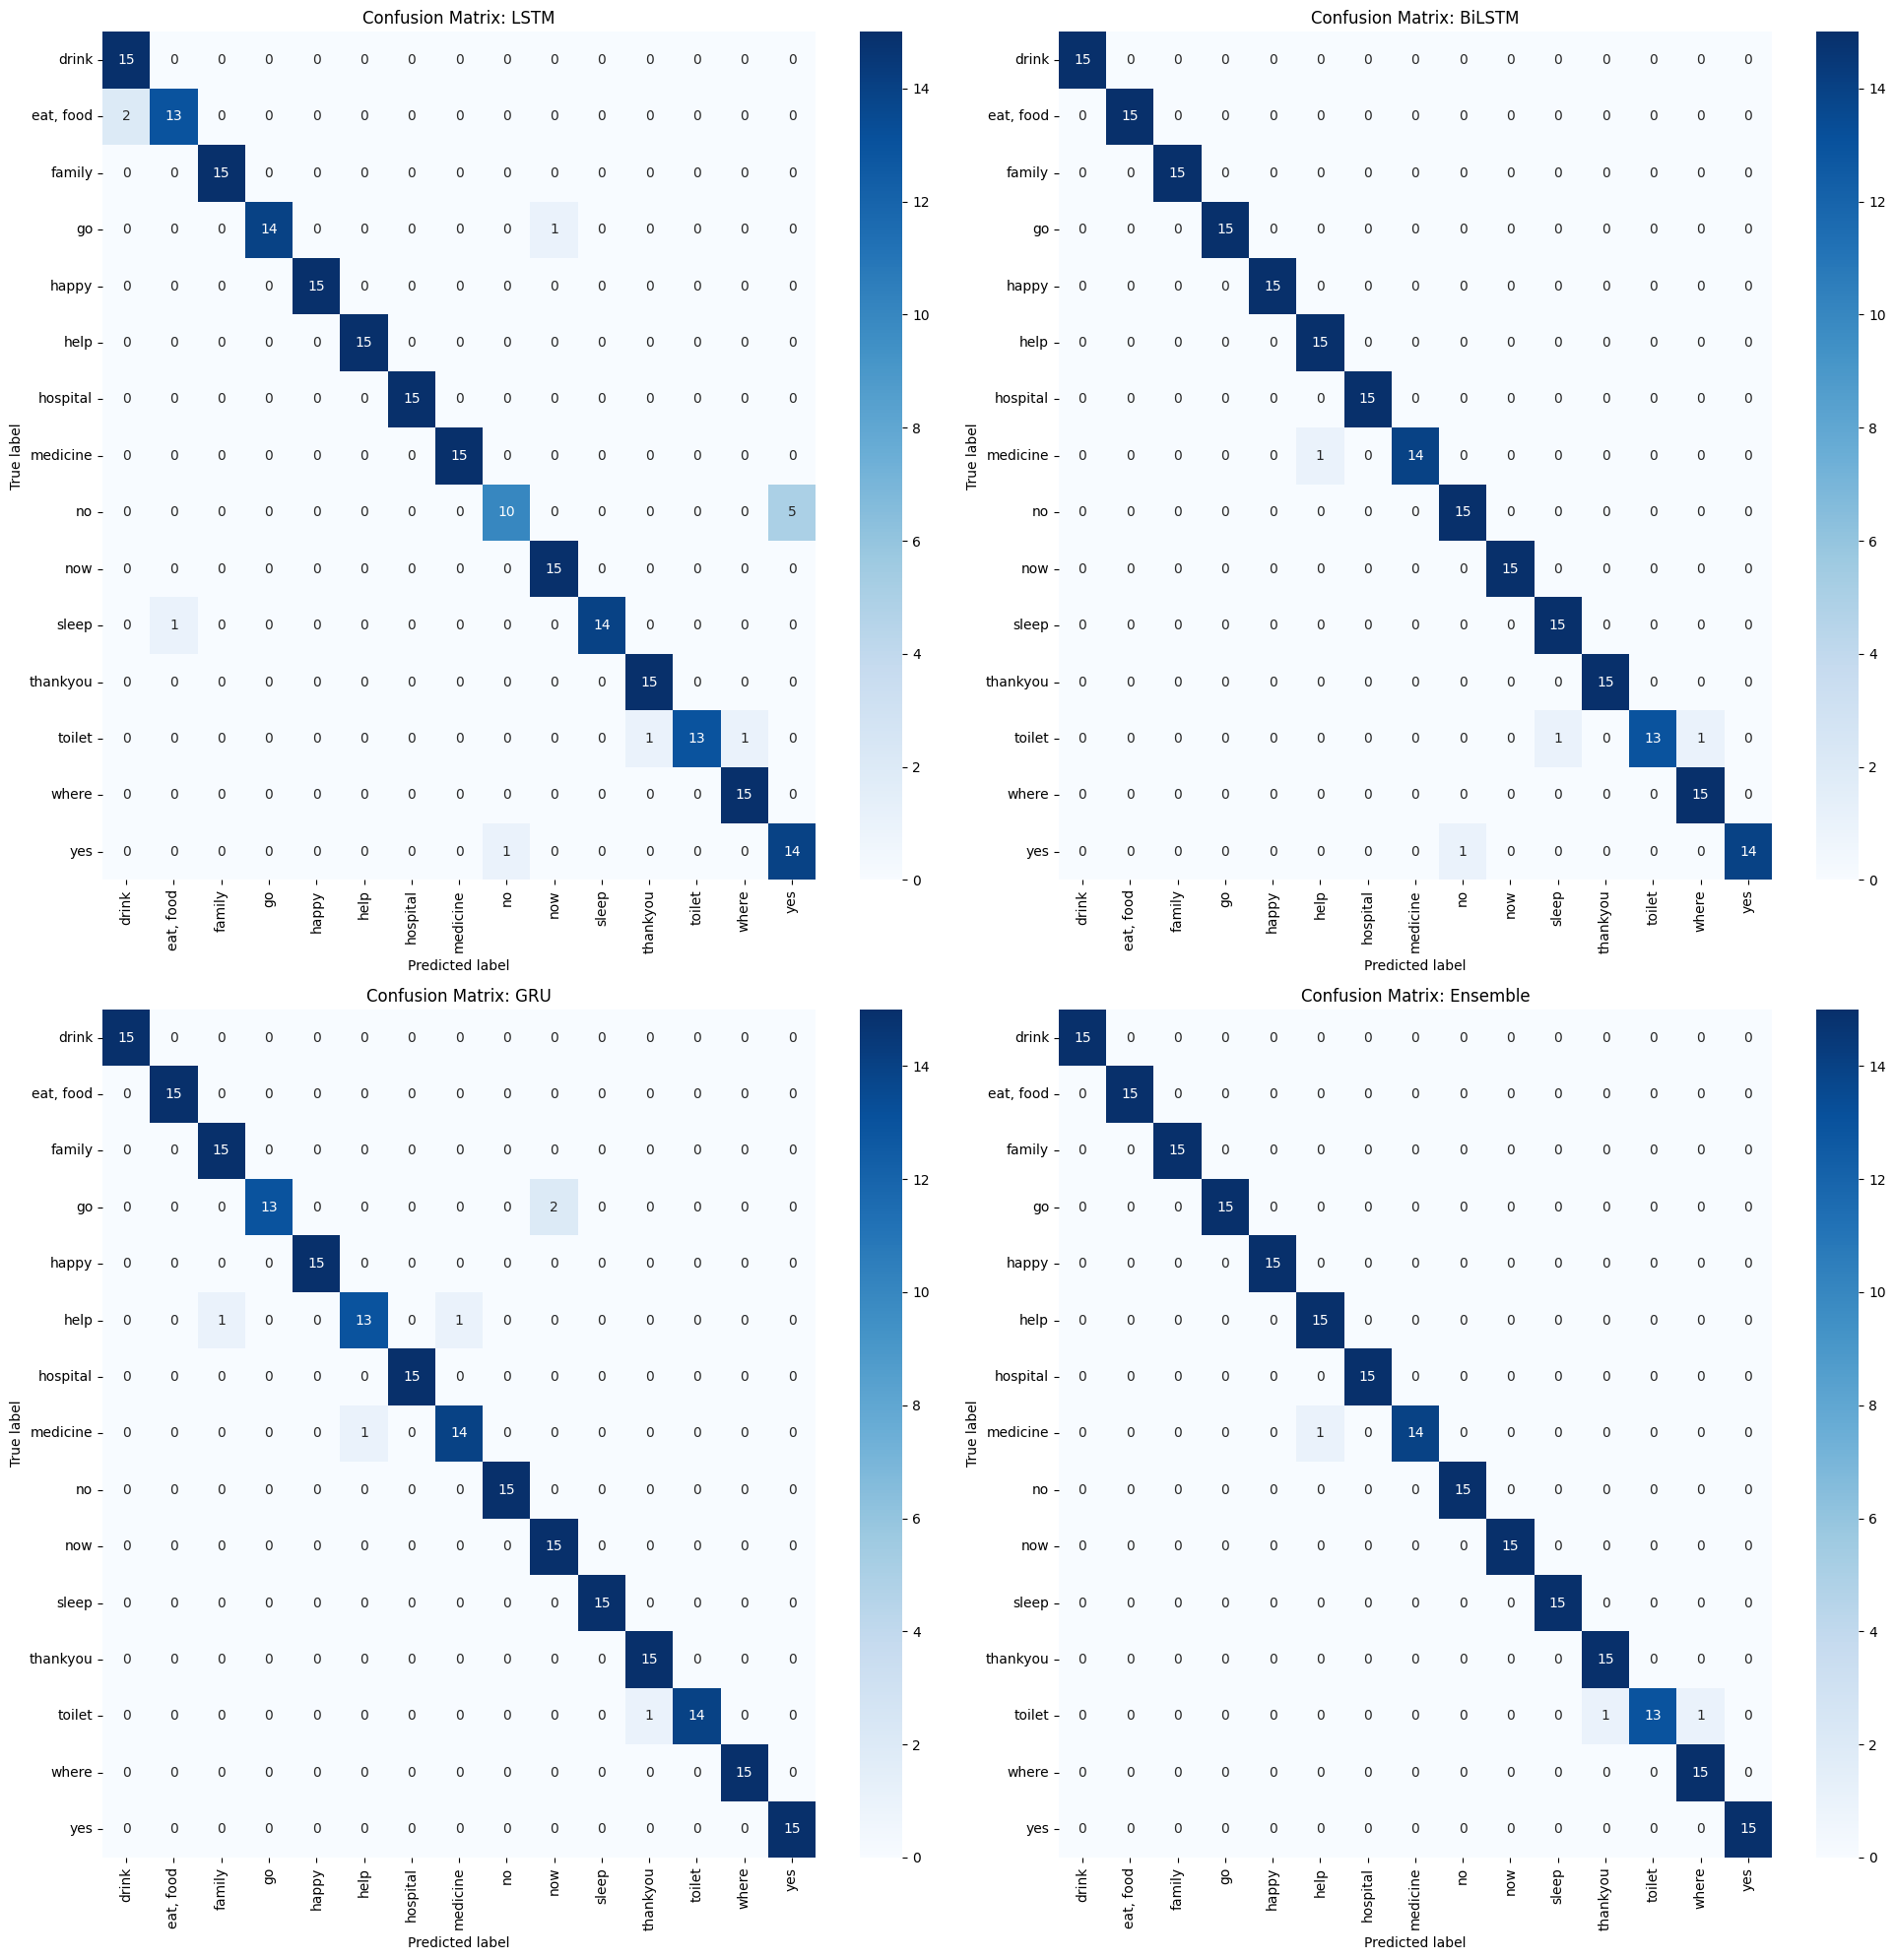

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# List of predictions and titles
predictions = [
    (y_pred1, "LSTM"),
    (y_pred2, "BiLSTM"),
    (y_pred3, "GRU"),
    (y_pred_ensemble, "Ensemble")
]

# Get class names (if you have them)
class_names = actions  # or replace with your list of class labels

plt.figure(figsize=(20, 20))
for i, (y_pred, title) in enumerate(predictions, 1):
    plt.subplot(2, 2, i)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

y_true = np.argmax(y_test, axis=1)
y_pred1 = np.argmax(preds1, axis=1)
y_pred2 = np.argmax(preds2, axis=1)
y_pred3 = np.argmax(preds3, axis=1)
ensemble_probs = (preds1 + preds2 + preds3) / 3.0
y_pred_ensemble = np.argmax(ensemble_probs, axis=1)

# Calculate accuracy for each model
acc1 = accuracy_score(y_true, y_pred1)
acc2 = accuracy_score(y_true, y_pred2)
acc3 = accuracy_score(y_true, y_pred3)
acc_ensemble = accuracy_score(y_true, y_pred_ensemble)

print(f"LSTM Accuracy:      {acc1:.4f}")
print(f"BiLSTM Accuracy:    {acc2:.4f}")
print(f"GRU Accuracy:       {acc3:.4f}")
print(f"Ensemble Accuracy:  {acc_ensemble:.4f}")

LSTM Accuracy:      0.9467
BiLSTM Accuracy:    0.9822
GRU Accuracy:       0.9733
Ensemble Accuracy:  0.9867


In [46]:
# For LSTM
lstm_train_loss = history1.history['loss'][-1]
lstm_val_loss = history1.history['val_loss'][-1]

# For BiLSTM
bilstm_train_loss = history2.history['loss'][-1]
bilstm_val_loss = history2.history['val_loss'][-1]

# For GRU
gru_train_loss = history3.history['loss'][-1]
gru_val_loss = history3.history['val_loss'][-1]

print(f"LSTM      - Final Training Loss: {lstm_train_loss:.4f}, Final Validation Loss: {lstm_val_loss:.4f}")
print(f"BiLSTM    - Final Training Loss: {bilstm_train_loss:.4f}, Final Validation Loss: {bilstm_val_loss:.4f}")
print(f"GRU       - Final Training Loss: {gru_train_loss:.4f}, Final Validation Loss: {gru_val_loss:.4f}")

LSTM      - Final Training Loss: 0.2216, Final Validation Loss: 0.2039
BiLSTM    - Final Training Loss: 0.1144, Final Validation Loss: 0.1380
GRU       - Final Training Loss: 0.2499, Final Validation Loss: 0.1683


# 8. Save Weights

In [ ]:
# model.save('model3.h5')

In [92]:
# # to load back model
model2.load_weights('model2.h5')

# 9. Real Time Testing

In [65]:
def prob_viz(res, actions, input_frame):
    output_frame = input_frame.copy()
    top_idx = np.argmax(res)
    prob = res[top_idx]
    color = (245, 117, 16)  # Single color for all classes
    cv2.rectangle(output_frame, (0, 60), (int(prob * 100), 90), color, -1)
    cv2.putText(output_frame, actions[top_idx], (0, 85), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

In [70]:
#detection variables
sequence = []     #collect frames to generate prediction
sentence = []     #prediction history
predictions = []
threshold = 0.95   #confidence matrix


cap = cv2.VideoCapture(0) # Accessing webcam
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
    
        # Make detection
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_landmarks(image, results)

        #make prediction
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model1.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:            
                        if actions[np.argmax(res)] != sentence[-1]:    #check if not same action 
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
    
            if len(sentence) > 5:
                sentence = sentence[-5:]
    
            #visualization probability
            image = prob_viz(res, actions, image)
        
        #rendering text
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        #break
        if cv2.waitKey(10) & 0xFF == ord('q'): # If key = 'q' then quit
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [22]:
cap.release()
cv2.destroyAllWindows()